In [1]:
import numpy
import pandas
import nibabel as nib
import SimpleITK as sitk
from datetime import datetime
import cc3d
import os
import subprocess

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch

### steps are: 

- [x] load the preprocessed image.

- [x] run synth seg

- [ ] resample the image back to the size of the preprocessed image.

- [ ] check that it aligns properly

- [ ] delete any extra files created by synthseg

- [ ] extract just the ventricle components

- [ ] create the 10mm area around the ventricles using euclidian distance.

- [ ] save a file that contains just the ventricle and the DWMH / PVWMH area? (0 = background, 1 = deep, 2 = PV, 3 = ventricle

- [ ] turn this into a script that I can run on all the images

In [4]:
folder = "/home/s2208943/ipdis/data/preprocessed_data/MSS3_InterRaterData/imgs/"
file = "MSS3_ED_004_V1_T1.nii.gz"
path = folder + file

In [5]:
orig = nib.load(path)
odata = orig.get_fdata()

In [6]:
#subprocess.run(['sh', 'vent_seg.sh', path, "/home/s2208943/test_synthseg_file"])

### creating the DWMH vs PVWMH area using euclidian distance as opposed to a structural element.


Then I should do it in the synthseg space since the spacing is 1.1.1. My euclidian distance code should assert that the pixels are of the same size in that code as well.

In [7]:
from scipy.ndimage import distance_transform_edt
import numpy as np
from twaidata.MRI_preprep.io import save_nii_img, load_nii_img

In [8]:
# synthseg_file = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg.nii.gz"

In [9]:
# synthseg, synthseg_header = load_nii_img(synthseg_file)

In [10]:
# ventricle_seg = ((synthseg == 4) | (synthseg == 43)).astype(np.float32)

In [11]:
# distance_map = distance_transform_edt(1 - ventricle_seg)

In [12]:
# save_nii_img("/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_vent_distance.nii.gz", distance_map, synthseg_header)

### resampling the ventricle segmentation images

In [13]:
from twaidata.MRI_preprep.resample import resample_and_return, resample_and_save
import SimpleITK as sitk

In [14]:
synthseg_file = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg.nii.gz"
resampled = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg_resampled.nii.gz"
distance_map_file = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_vent_distance.nii.gz"
resampled_dmap = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_vent_distance_resampled.nii.gz"

In [15]:
outspacing = sitk.ReadImage(path).GetSpacing() # get the spacing from the preprocessed image
print(outspacing)
resample_and_save(synthseg_file, resampled, is_label=True, out_spacing=outspacing, overwrite=True)
resample_and_save(distance_map_file, resampled_dmap, is_label=False, out_spacing=outspacing, overwrite=True)

(1.0, 1.0, 3.0)
original spacing:  None
using original spacing derived from image
original spacing:  None
using original spacing derived from image


In [16]:
### load the resampled synthseg
data = nib.load(resampled).get_fdata()
data = torch.from_numpy(data)
data = data[0:odata.shape[0], 0:odata.shape[1], 0:odata.shape[2]]

distance_map = nib.load(resampled_dmap).get_fdata()
distance_map = torch.from_numpy(distance_map)
distance_map = distance_map[0:odata.shape[0], 0:odata.shape[1], 0:odata.shape[2]]

### visualizing the results

In [17]:
img = torch.ones([*data.shape, 4])
img[:,:,:,1] = (data != 4)
img[:,:,:,2] = (data != 43)
img[:,:,:,3] = (data == 4) | (data == 43) # alpha channel

In [18]:
import proplot as pplt

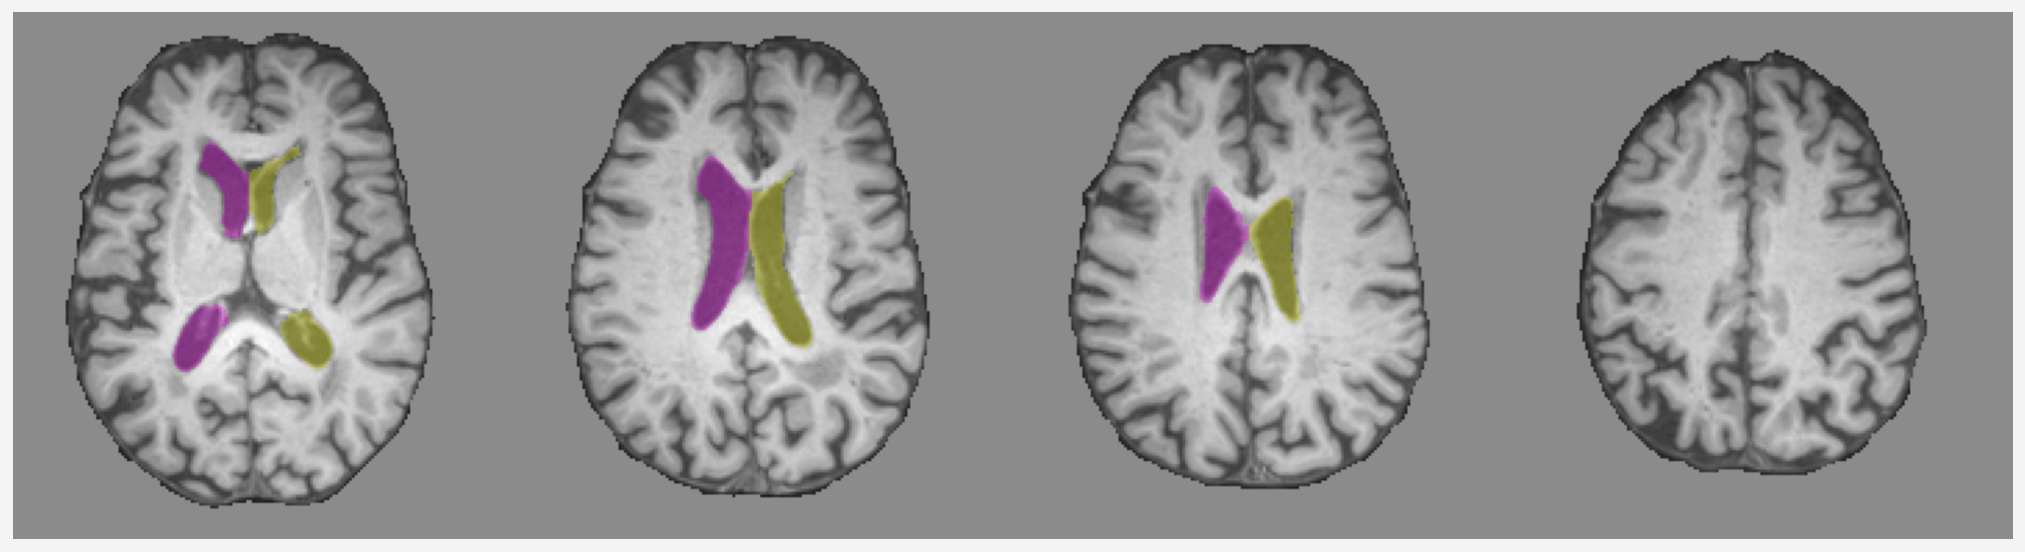

In [43]:
fig = pplt.figure(space=0, refwidth='20em')
axs = fig.subplots(nrows=1, ncols=4)

islice = 30
axs[0].imshow(np.rot90(odata[30:-30:,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[0].imshow(np.rot90(img[30:-30,10:-40,islice]), alpha=0.3)

islice = 33
axs[1].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[1].imshow(np.rot90(img[30:-30,10:-40,islice]), alpha=0.3)

islice = 35
axs[2].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[2].imshow(np.rot90(img[30:-30,10:-40,islice]), alpha=0.3)

islice = 38
axs[3].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[3].imshow(np.rot90(img[30:-30,10:-40,islice]), alpha=0.3)

for ax in axs:
    ax.axis('off')
    for spine in ax.spines:
        ax.spines[spine].set_color('none')
        
fig.save("synthseg - synthseg ventricle segmentation example.png")

In [ ]:
fig = pplt.figure(space=0, refwidth='20em')
axs = fig.subplots(nrows=1, ncols=4)

islice = 30
axs[0].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[0].imshow(np.rot90(distance_map[30:-30,10:-40,islice]), alpha=0.8, vmin=distance_map.min(), vmax=distance_map.max())

islice = 33
axs[1].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[1].imshow(np.rot90(distance_map[30:-30,10:-40,islice]), alpha=0.8, vmin=distance_map.min(), vmax=distance_map.max())

islice = 35
axs[2].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[2].imshow(np.rot90(distance_map[30:-30,10:-40,islice]), alpha=0.8, vmin=distance_map.min(), vmax=distance_map.max())

islice = 38
axs[3].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[3].imshow(np.rot90(distance_map[30:-30,10:-40,islice]), alpha=0.8, vmin=distance_map.min(), vmax=distance_map.max())

for ax in axs:
    ax.axis('off')
    for spine in ax.spines:
        ax.spines[spine].set_color('none')
        
fig.save("synthseg - distance map from ventricle segmentation.png")

In [ ]:
PV_region = distance_map < 10
PV_region_img = torch.ones([*PV_region.shape, 4])

PV_region_img[:,:,:,2] = 0.5 # create a pastel yellow
PV_region_img[:,:,:,3] = PV_region

In [ ]:
fig = pplt.figure(space=0, refwidth='20em')
axs = fig.subplots(nrows=1, ncols=4)

islice = 30
axs[0].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[0].imshow(np.rot90(PV_region_img[30:-30,10:-40,islice]), alpha=0.8)

islice = 33
axs[1].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[1].imshow(np.rot90(PV_region_img[30:-30,10:-40,islice]), alpha=0.8)

islice = 35
axs[2].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[2].imshow(np.rot90(PV_region_img[30:-30,10:-40,islice]), alpha=0.8)

islice = 38
axs[3].imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray', vmin=-3, vmax=2.5)
axs[3].imshow(np.rot90(PV_region_img[30:-30,10:-40,islice]), alpha=0.8)

for ax in axs:
    ax.axis('off')
    for spine in ax.spines:
        ax.spines[spine].set_color('none')
        
fig.save("synthseg - PV region as found in distance map.png")

In [ ]:
### other code

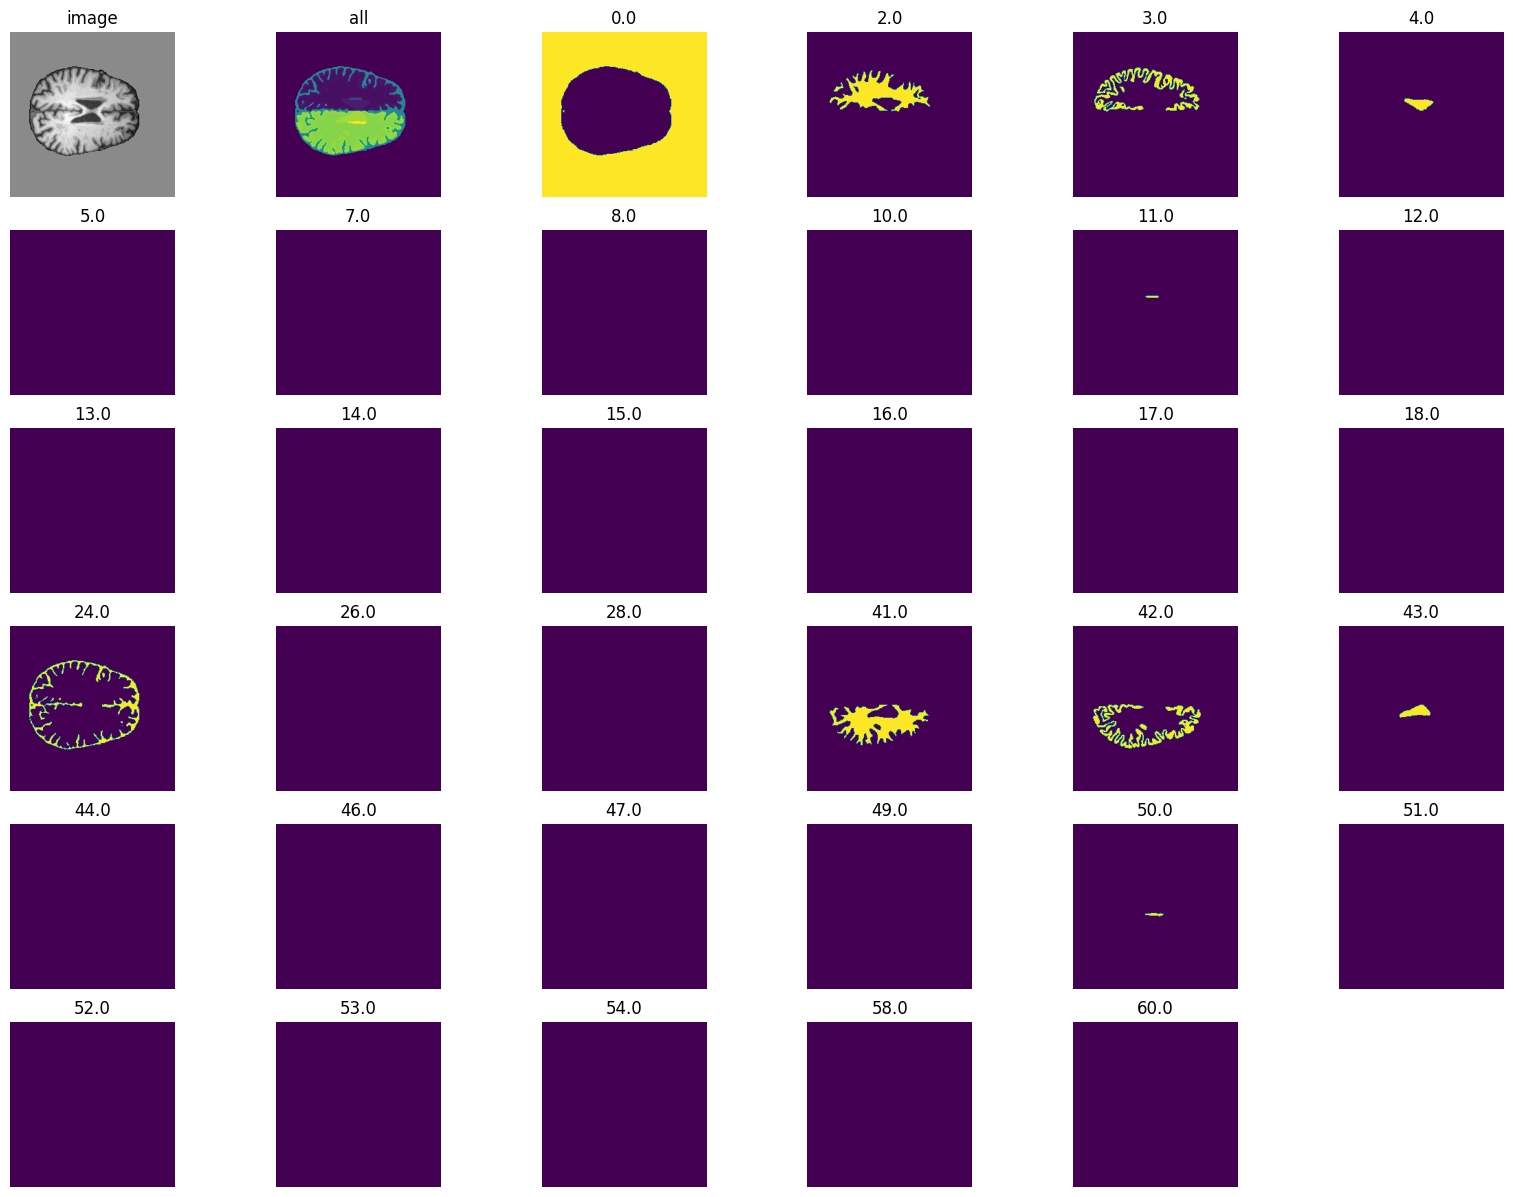

In [63]:
islice = 35
plt.figure(figsize=(20, 15))
plt.subplot(6, 6, 1)
plt.imshow(np.rot90(odata[30:-30,10:-40,islice]), cmap='gray')
plt.axis('off')
plt.title("image")
plt.subplot(6, 6, 2)
plt.imshow(np.rot90(data[30:-30,10:-40,islice]))
plt.axis('off')
plt.title("all")
for i, ccid in enumerate(data.unique()):
    plt.subplot(6,6,i+3)
    plt.imshow(np.rot90(data[30:-30,10:-40,islice])==ccid)
    plt.axis('off')
    plt.title(ccid.item())
